### Packages

In [10]:
from esda.moran import Moran
from libpysal.weights import Queen, KNN
import seaborn as sb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from clustergram import Clustergram
from sklearn.preprocessing import robust_scale
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.spatial.distance import cdist

### Data

In [14]:
# main gdf
popgridmanchester = gpd.read_file("popgridmanchesterlatest.gpkg")

# subset of variables of interest
popgridsub = popgridmanchester.iloc[:,36:60]

# remove nans
popgridsub = popgridsub.dropna()

In [5]:
# health data
healthdata = gpd.read_file("Greater_Manchester_NH_GIS.gpkg")

### Spatial autocorrelation tests

In [15]:
# variables of interest
cluster_variables = [col for col in popgridsub.columns if col != "geometry"]

# creating weight matrix
w = Queen.from_dataframe(popgridsub)
w2 = KNN.from_dataframe(popgridsub)

In [12]:
# Calculate Moran's I for each variable
mi_results = [
    Moran(popgridsub[variable], w) for variable in cluster_variables
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
buffer_NDVI_mean,0.995702,0.001
buffer_LST_mean,0.997281,0.001
buffer_DEM_mean,0.999596,0.001
buffer_NightLight_mean,0.998159,0.001
dist_to_restaurant,0.912965,0.001
dist_to_bus_stop,0.905582,0.001
dist_to_daily_shops,0.945485,0.001
dist_to_business_shops,0.976127,0.001
dist_to_greenspace,0.905040,0.001


In [ ]:
# Calculate Moran's I for each variable
mi_results2 = [
    Moran(popgridsub[variable], w2) for variable in cluster_variables
]
# Structure results as a list of tuples
mi_results2 = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results2)
]
# Display on table
table2 = pandas.DataFrame(
    mi_results2, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table2

### Spatial constrained hierarchical clustering

In [26]:
# Robust scaling due to the range of values differing between variables
popgridsub_scaled = robust_scale(popgridsub[cluster_variables])

# Spatial clustering
# Specify cluster model with spatial constraint
sp_hier_model = AgglomerativeClustering(
    linkage="ward", connectivity=w.sparse, n_clusters=8, 
)

# Fit algorithm to the data
sp_hier_model.fit(popgridsub_scaled)

# clustergram, do later due to time
#cgram = Clustergram(range(1, 10), n_init=100, verbose=False)
#cgram.fit(popgridsub_scaled)

/Users/Julian/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 73 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


AgglomerativeClustering(connectivity=<322284x322284 sparse matrix of type '<class 'numpy.float64'>'
	with 2344362 stored elements in Compressed Sparse Row format>,
                        n_clusters=8)

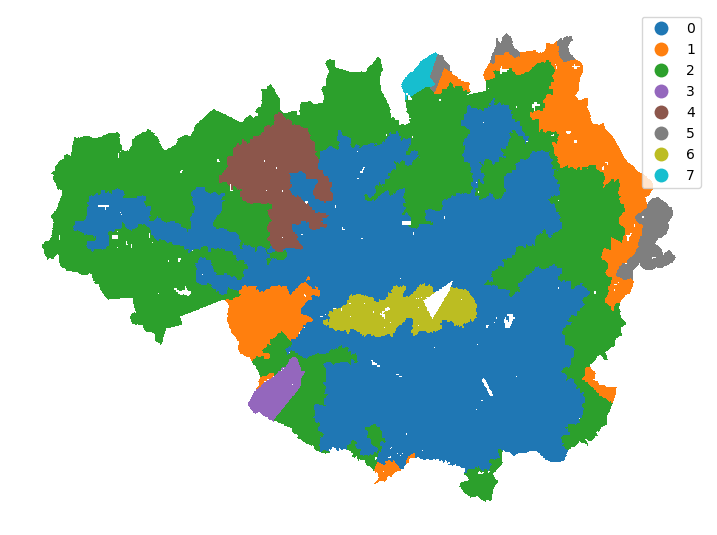

In [27]:
# plotting results
popgridsub["sp_hier_label"] = sp_hier_model.labels_
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="sp_hier_label",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

### K-means clustering

In [17]:
inertias = []
mapping = {}

K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(popgridsub_scaled)
    kmeanModel.fit(popgridsub_scaled)
    # Check the inertia amount
    inertias.append(kmeanModel.inertia_)
    mapping[k] = kmeanModel.inertia_

/Users/Julian/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Julian/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Julian/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Julian/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

In [18]:
# Show inertia score per clusteramount
for key, val in mapping.items():
    print(f'{key} : {val}')

1 : 8351636.691695557
2 : 5494591.281866489
3 : 4681680.4010711415
4 : 4147823.706753294
5 : 3805918.845623615
6 : 3592321.0510536777
7 : 3404787.718989657
8 : 3273978.3985772966
9 : 3153074.6641536662


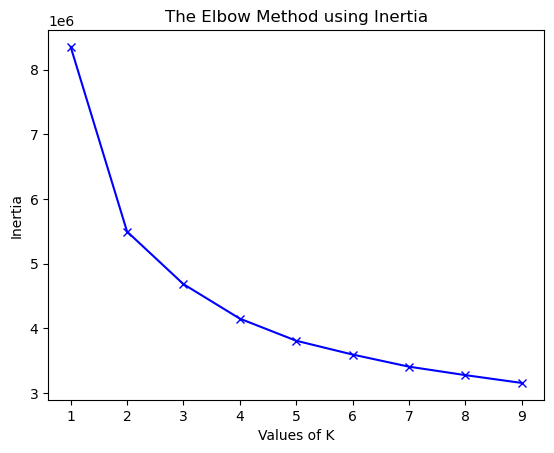

In [19]:
# plotting elbow plot
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [23]:
# model of 8 clusters
KmeanModel = KMeans(n_clusters=k, n_init=20)
kmeans = KmeanModel.fit(popgridsub_scaled)

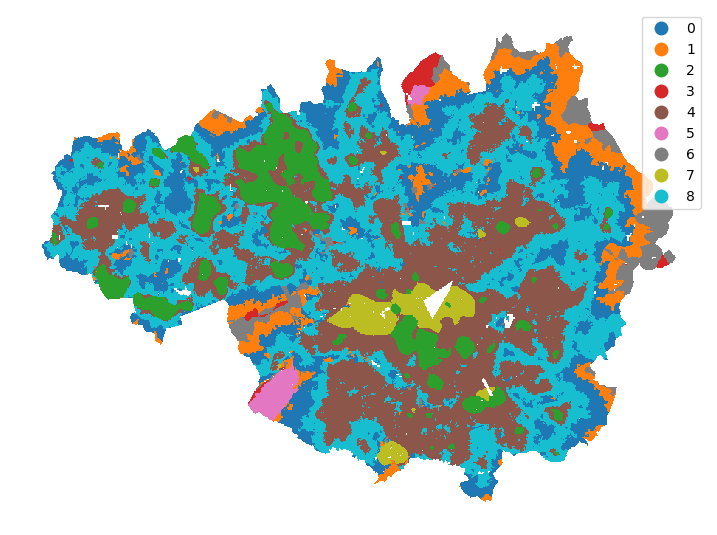

In [25]:
# plotting results
popgridsub["Kmeans_label"] = kmeans.labels_
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="Kmeans_label",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()